In [152]:
!pip install -U keras
!pip install -U tensorflow

Requirement already up-to-date: keras in c:\users\losh\appdata\local\programs\python\python38\lib\site-packages (2.7.0)

You should consider upgrading via the 'c:\users\losh\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.



Requirement already up-to-date: tensorflow in c:\users\losh\appdata\local\programs\python\python38\lib\site-packages (2.7.0)


You should consider upgrading via the 'c:\users\losh\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [154]:
import numpy as np
import pandas as pd
from scipy import sparse

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, GRU
from keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
# from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline

In [ ]:
import csv
import pandas as pd
join_BID_tor_v2 = pd.read_csv('D:\Ryerson\CIND820\Kaggle_yelp_dataset_CSV\join_BID_tor_v2.csv')

In [209]:
join_BID_tor_v2_samp = join_BID_tor_v2.sample(n = 20433 , random_state = 42)
train = join_BID_tor_v2_samp[0:18000]
test = join_BID_tor_v2_samp[18000:]

In [194]:
train.shape, test.shape

((16000, 23), (4433, 23))

,text,stars_y
14278,"Staff is rude, not helpful at all. That is whe...",1
16224,This is a nice place to come to catch up with ...,4
7646,Hands down the best vegan bakery in Toronto! \...,5
1402,"I was impressed, they have here the same starb...",4
1328,I don't understand why there is hype around th...,1


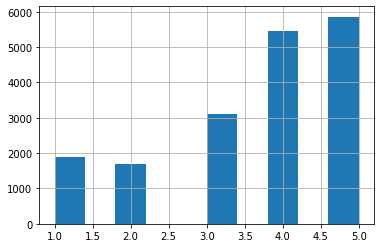

In [211]:
train = train[['text', 'stars_y']]
train['stars_y'].hist();train.head()

In [212]:
train = pd.get_dummies(train, columns = ['stars_y'])
train.head()

,text,stars_y_1,stars_y_2,stars_y_3,stars_y_4,stars_y_5
14278,"Staff is rude, not helpful at all. That is whe...",1,0,0,0,0
16224,This is a nice place to come to catch up with ...,0,0,0,1,0
7646,Hands down the best vegan bakery in Toronto! \...,0,0,0,0,1
1402,"I was impressed, they have here the same starb...",0,0,0,1,0
1328,I don't understand why there is hype around th...,1,0,0,0,0


In [213]:
#test = pd.read_csv('/home/adam/R/Yelp/dataset/model_test.csv', usecols=['text', 'stars'])
test = test[['text', 'stars_y']]
test = pd.get_dummies(test, columns = ['stars_y'])
train.shape, test.shape

((18000, 6), (2433, 6))

In [182]:
# set frac = .33 to subsample in the initial trainings (to increase efficeny if needed)
# train_samp = train.sample(frac = .33, random_state = 42)
# test_samp = test.sample(frac = .33, random_state = 42)
# train_samp.shape, test_samp.shape   

((5280, 6), (1463, 6))

In [214]:
# max_features is an upper bound on the number of words in the vocabulary
max_features = 2000
tfidf = TfidfVectorizer(max_features = max_features)

In [189]:
class NBFeatures(BaseEstimator):
    def __init__(self, alpha):
        # Smoothing Parameter: always going to be one for my use
        self.alpha = alpha
        
    def preprocess_x(self, x, r):
        return x.multiply(r)
    
    # calculate probabilities
    def pr(self, x, y_i, y):
        p = x[y == y_i].sum(0)
        return (p + self.alpha)/((y==y_i).sum()+self.alpha)
    
    # calculate the log ratio and represent as sparse matrix
    # ie fit the nb model
    def fit(self, x, y = None):
        self._r = sparse.csr_matrix(np.log(self.pr(x, 1, y) /self.pr(x, 0, y)))
        return self
    
    # apply the nb fit to original features x
    def transform(self, x):
        x_nb = self.preprocess_x(x, self._r)
        return x_nb

In [215]:
# Create pipeline using sklearn pipeline:
    # I basically create my tfidf features which are fed to my NB model 
    # for probability calculations. Then those are fed as input to my 
    # logistic regression model.
lr = LogisticRegression()
nb = NBFeatures(1)
p = Pipeline([
    ('tfidf', tfidf),
    ('nb', nb),
    ('lr', lr)
])

In [216]:
class_names = ['stars_y_1', 'stars_y_2', 'stars_y_3', 'stars_y_4', 'stars_y_5']
scores = []
preds = np.zeros((len(test_samp), len(class_names)))
for i, class_name in enumerate(class_names):
    train_target = train_samp[class_name]    
    cv_score = np.mean(cross_val_score(estimator = p, X = train_samp['text'].values, 
                                      y = train_target, cv = 3, scoring = 'accuracy'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))
    p.fit(train_samp['text'].values, train_target)
    preds[:,i] = p.predict_proba(test_samp['text'].values)[:,1]

CV score for class stars_y_1 is 0.9187500000000001
CV score for class stars_y_2 is 0.9071969696969697
CV score for class stars_y_3 is 0.8320075757575758
CV score for class stars_y_4 is 0.6914772727272727
CV score for class stars_y_5 is 0.7770833333333335


In [217]:
t = metrics.classification_report(np.argmax(test_samp[class_names].values, axis = 1),np.argmax(preds, axis = 1))
print(t)

              precision    recall  f1-score   support

           0       0.66      0.57      0.61       156
           1       0.43      0.10      0.16       121
           2       0.53      0.27      0.36       232
           3       0.47      0.60      0.53       474
           4       0.64      0.77      0.70       480

    accuracy                           0.56      1463
   macro avg       0.55      0.46      0.47      1463
weighted avg       0.55      0.56      0.54      1463

